# Unet for multi-class segmentation
Train and predict

## Chalange description

The data is 3D MRI images with 4 channels:
* Flair
* T1
* T1ce
* T2

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema 
* Label 4: enhancing tumor

In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:
> (155, 240, 240, 4)
> For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

In [2]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [3]:
DATA= 'dicom/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = 'dicom/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'/HGG/'
DATA_LGG = DATA +'/LGG/'

NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Training/numpy_images/'
VALIDATION_NUMPY_DIR = 'dicom/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [4]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [5]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [6]:
import pandas
import numpy

In [7]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
from random import randrange
from keras.utils import np_utils

Using TensorFlow backend.


## Visualization utilities

In [8]:

from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
from visualization_utils import show_lable_on_image4
reload(vu)

<module 'visualization_utils' from 'C:\\env\\visualization_utils.py'>

In [9]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.] #[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [10]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);
    

In [11]:
def show_lable(lbl):
    
    
    vu.show_n_images([lbl[:,:,k] for k in range(4)]+[lbl_from_cat(lbl)],
                 titles = label_type_shrt + ['Label']) 

In [12]:
def show_pred_im_lable(im, lb, pred):
    
    vu.show_n_images([im[:,:,1], lb[:,:], 
                   show_lable_on_image4(im[:,:,1], lb[:,:]),
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair', 'Label', 'Label on T1', 'Prediction on Flair'])

In [13]:
def show_pred_im(im, pred):
    
    vu.show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

## Read image description files
In the preprocessing notebook, all files where saved as numpy.

Some statistics on the labels were collected, to assist the training phase.

In [14]:
df_train= pd.read_csv('df_train.csv')
df_test= pd.read_csv('df_test.csv')
df_val= pd.read_csv('df_val.csv')

In [15]:
print(df_test)

   Grade                    id     lab0    lab1    lab2   lab3  rmin  rmax  \
0    LGG  BraTS19_TCIA09_255_1  8697118  110787  118819   1276    28   111   
1    LGG  BraTS19_TCIA13_618_1  8859707   50291   18002      0    26    91   
2    HGG  BraTS19_TCIA03_498_1  8850722    7328   55793  14157    40   102   
3    HGG   BraTS19_CBICA_AQU_1  8827121   10976   63649  26254    45   132   
4    HGG   BraTS19_CBICA_ASK_1  8844582    1588   75783   6047    52   127   
5    HGG   BraTS19_CBICA_BGW_1  8804368   32906   71184  19542    69   138   
6    LGG  BraTS19_TCIA10_490_1  8814711   74556   31120   7613    58   122   
7    HGG  BraTS19_TCIA08_436_1  8805266   37590   58885  26259    55   117   
8    LGG  BraTS19_TCIA13_615_1  8802647  124159       0   1194    49   126   
9    LGG  BraTS19_TCIA12_470_1  8907275    2705   14226   3794    58    99   
10   HGG   BraTS19_TMC_30014_1  8835425    7519   42498  42558    70   141   
11   HGG  BraTS19_TCIA02_394_1  8877265   11141   18410  21184  

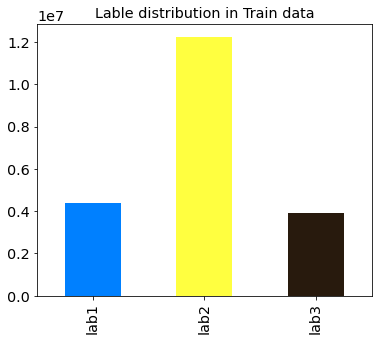

In [16]:
df_train[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Train data')

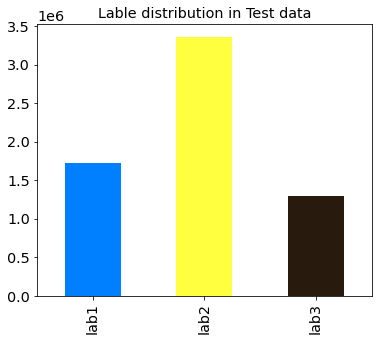

In [17]:
df_test[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Test data')

## Build Train generator

In [18]:
def get_numpy_img_lbl(img_id = 'BraTS19_2013_0_1', np_dir=NUMPY_DIR):
    img=np.load(os.path.join(np_dir, img_id+'.npy'))
    lbl=np.load(os.path.join(np_dir, img_id+'_lbl.npy'))
    return img,lbl

In [19]:
def get_random_img(axis=0, df=df_train, np_dir=NUMPY_DIR):
    
    ind = randrange(len(df))
    img_id= df.iloc[ind].id
    img,lbl = get_numpy_img_lbl(img_id, np_dir=NUMPY_DIR)
        
    if (axis==0):
        x = randrange(df.iloc[ind].rmin, df.iloc[ind].rmax+1)
        return img[ x,:,:, :], lbl[x,:,:]

    im = np.zeros((240,240,4),dtype=np.float32)    
    lb = np.zeros((240,240),dtype=np.int)
        
    if (axis==1):
        y = randrange(df.iloc[ind].cmin, df.iloc[ind].cmax+1)
        im[40:40+155,:,:]=img[:, y,:, :]
        lb[40:40+155,:]=lbl[:, y,:]
        return im,lb
    
    if (axis == 2):
        z = randrange(df.iloc[ind].zmin, df.iloc[ind].zmax+1)
        im[40:40+155,:,:]=img[:,:, z, :]
        lb[40:40+155,:]=lbl[:,:,z]
        return im,lb
    return None    

<Figure size 432x360 with 0 Axes>

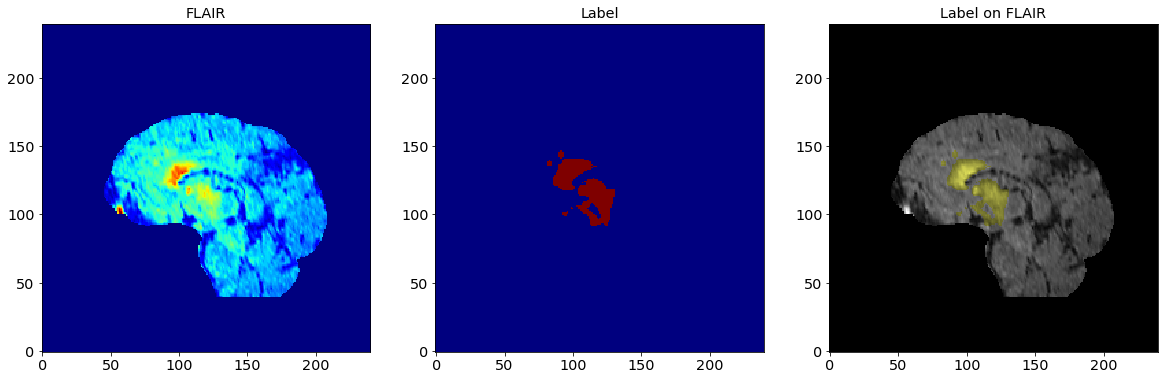

In [20]:
img,lbl = get_random_img(2)
show_img_lable(img, lbl)

Function randomly selects a 2D image that includes the given label

In [21]:
def get_img_for_label(lab=2, axis=0, df=df_train,np_dir = NUMPY_DIR):
    
    img_id= random.choice(df[df['lab'+str(lab)] > 0].id.values)
    
    img,lbl = get_numpy_img_lbl(img_id, np_dir)
    ind = np.where(lbl==lab)
    k = random.randrange(len(ind[0]))
    
    if (axis==0):        
        return img[ind[0][k],:,:] , lbl[ind[0][k],:,:]
        
    lb = np.zeros((240,240),dtype=np.int)
    im = np.zeros((240,240,4),dtype=np.float32)
    
    if (axis==1):
        im[40:40+155,:,:]=img[:, ind[1][k],:,:]
        lb[40:40+155,:]=lbl[:, ind[1][k],:]
        return im,lb
    
    if (axis == 2):
        im[40:40+155,:,:]=img[:, :, ind[2][k],:]
        lb[40:40+155,:]=lbl[:,:,ind[2][k]]
        return im,lb
    return None

<Figure size 432x360 with 0 Axes>

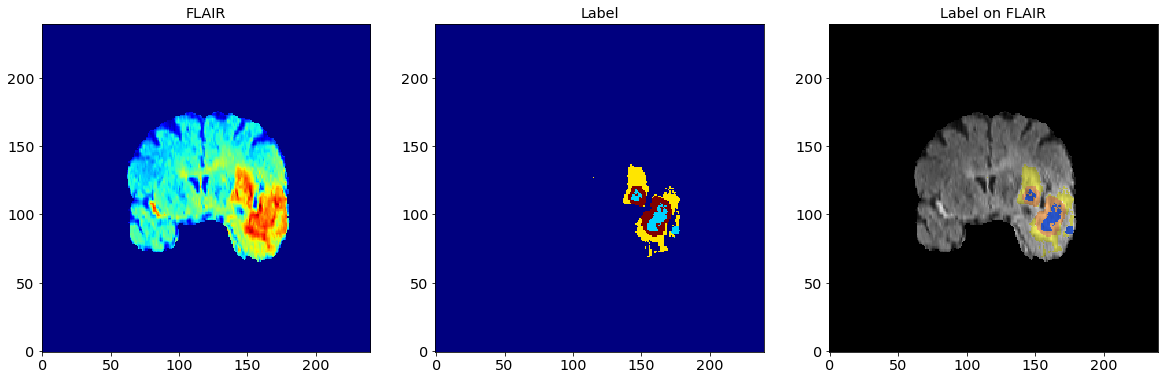

In [22]:
img,lbl = get_img_for_label(1,1)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

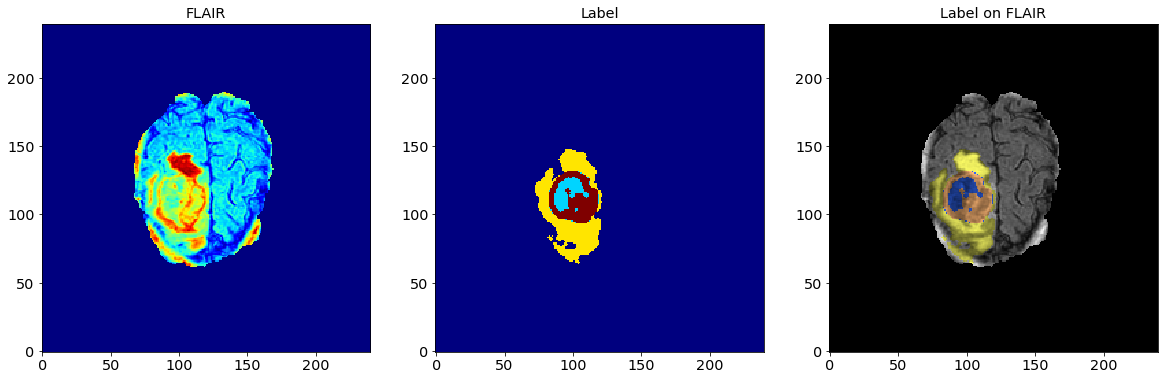

In [23]:
img,lbl = get_img_for_label(3,0)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

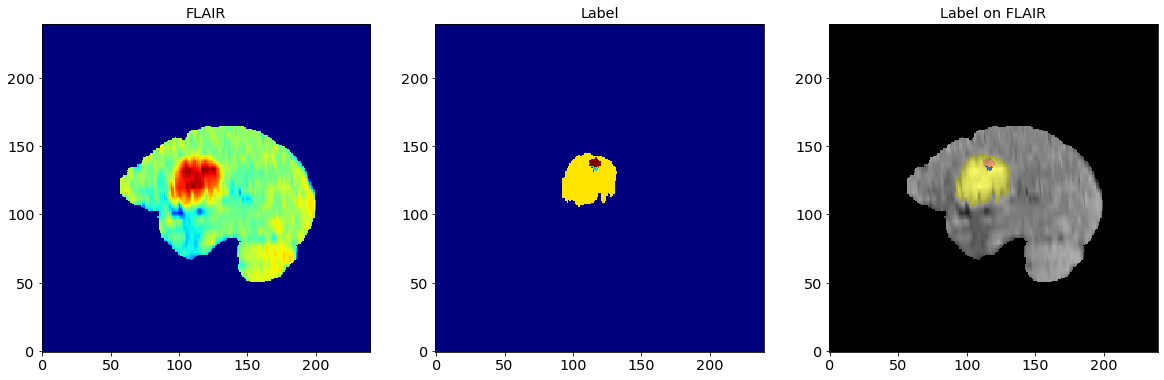

In [24]:
img,lbl = get_img_for_label(2,2)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

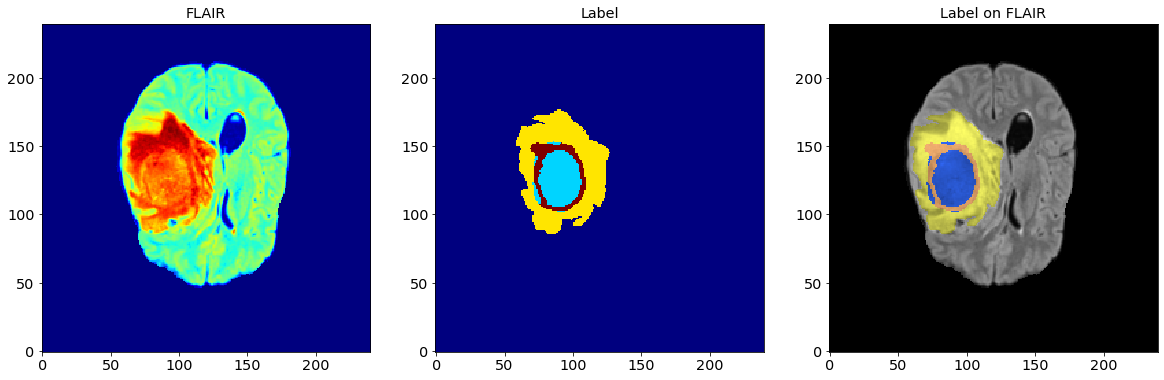

In [25]:
img,lbl = get_img_for_label(1,0)
show_img_lable(img, lbl)

In [26]:
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

For test we will create batch from few test images. only planes with lables >0 will be included.

In [27]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        for k in range(4):
            if (img[z,:,:,k].max()>0):
                img[z,:,:,k] /= img[z,:,:,k].max()
    return img

In [28]:
def normalize_2D_image(img):

        for c in range(4):
            if (img[:,:,c].max()>0):
                img[:,:,c] = img[:,:,c]/img[:,:,c].max()
        return img

Function returns all z-planes of the image that have non-zerolable

In [29]:
def get_img_batch(row, np_dir=NUMPY_DIR):
    
    im,lb = get_numpy_img_lbl(row['id'], np_dir)
    
    n_im = row['rmax']-row['rmin']
    rmin=row['rmin']
    rmax=row['rmax']
    print(rmax)
    print(rmin)
    
    return normalize_3D_image(im[rmin:rmax]), np_utils.to_categorical(lb[rmin:rmax],4)

82
35
(47, 240, 240, 4)
(47, 240, 240, 4)


<Figure size 432x360 with 0 Axes>

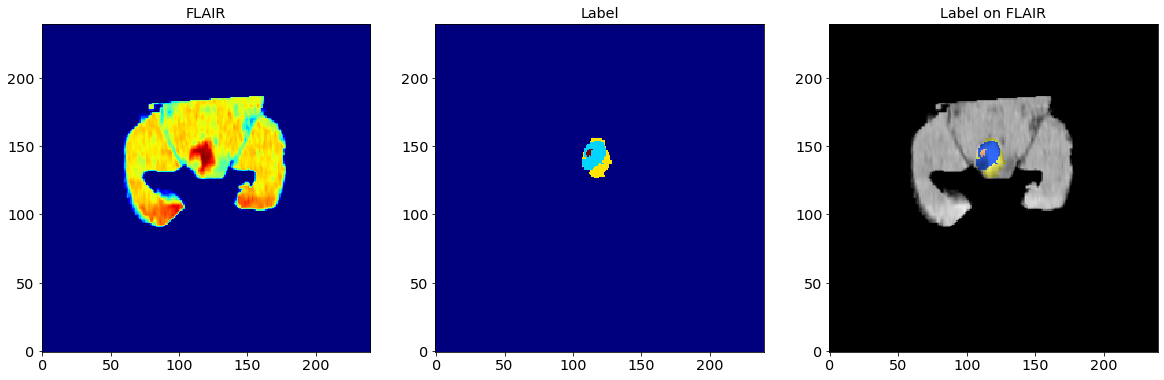

In [30]:
im, lb = get_img_batch(df_test.iloc[50])
im.shape, lb.shape
print(im.shape)
print(lb.shape)
show_img_lable(im[6], lb[6])

<Figure size 432x360 with 0 Axes>

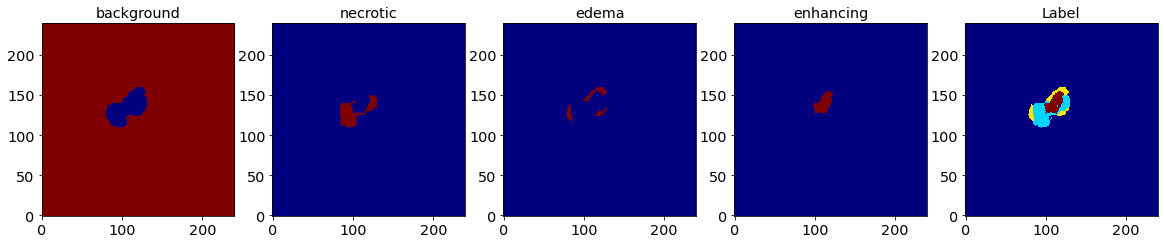

In [31]:
i=15
show_lable(lb[i])

Get images with non-zero labels from all raws of given data frame

In [32]:
def get_df_img_batch(df_batch, np_dir=NUMPY_DIR):
    
        n_images = (df_batch.rmax - df_batch.rmin).sum()
        b_images = np.zeros((n_images, 240, 240, 4), np.float32)
        b_label = np.zeros((n_images, 240, 240, 4), np.int8)    
        ind=0
        for index, row in df_batch.iterrows():
 
            b_im, b_lb = get_img_batch(row, np_dir)
            n_im = b_im.shape[0]
            b_images[ind:ind+n_im] = b_im
            b_label[ind:ind+n_im] = b_lb
            ind+=n_im
               
        return b_images, b_label

111
28
91
26
102
40


<Figure size 432x360 with 0 Axes>

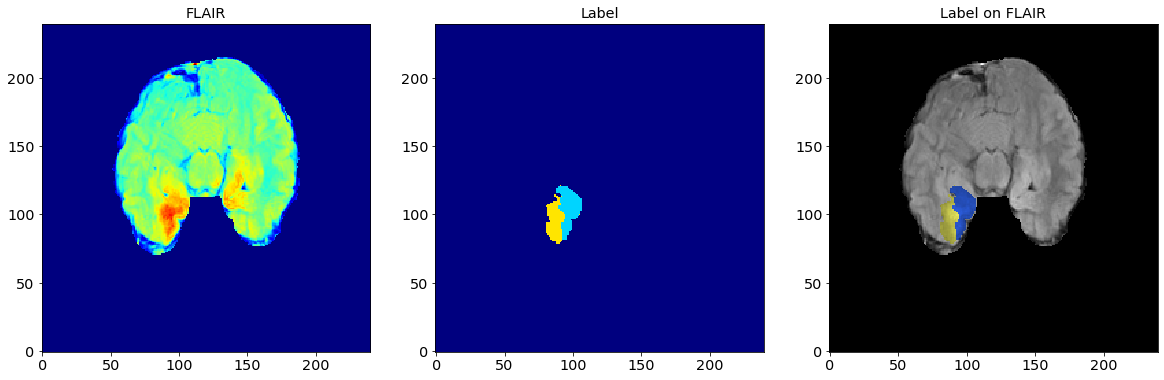

In [33]:
im, lb = get_df_img_batch(df_test.iloc[0:3])
show_img_lable(im[100],lb[100])

In [34]:
from keras.utils import np_utils
def generate_im_test_batch(n_images = 3, batch_size=30, df = df_test, np_dir=NUMPY_DIR):

    while 1:
         
        df_batch = df.sample(n_images)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        if (batch_size > 0):
            b_images = b_images[0:batch_size]
            b_label = b_label[0:batch_size]
            
        yield b_images, b_label

In [35]:
%%time
gen_test_im = generate_im_test_batch(5)
imtest,lbtest = next(gen_test_im)
imtest.shape, lbtest.shape

131
81
82
35
98
26
117
55
129
48
Wall time: 6.09 s


((30, 240, 240, 4), (30, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

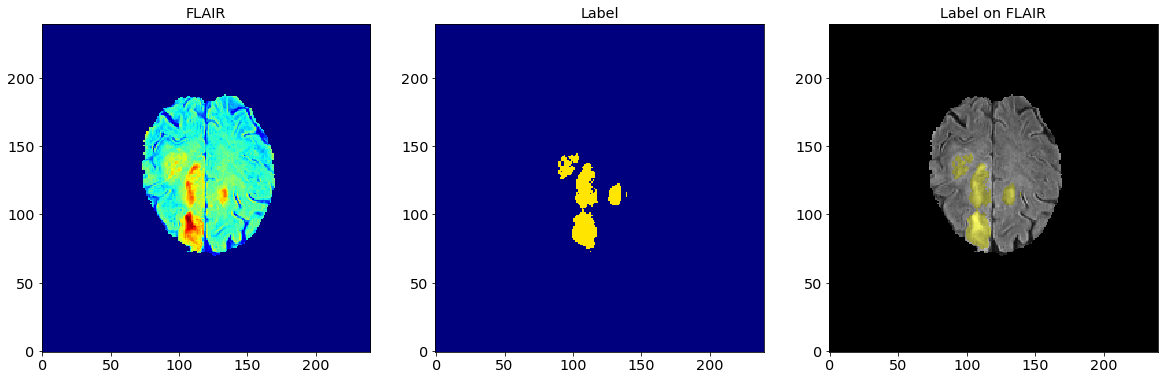

In [36]:
show_img_lable(imtest[10], lbtest[10])

<Figure size 432x360 with 0 Axes>

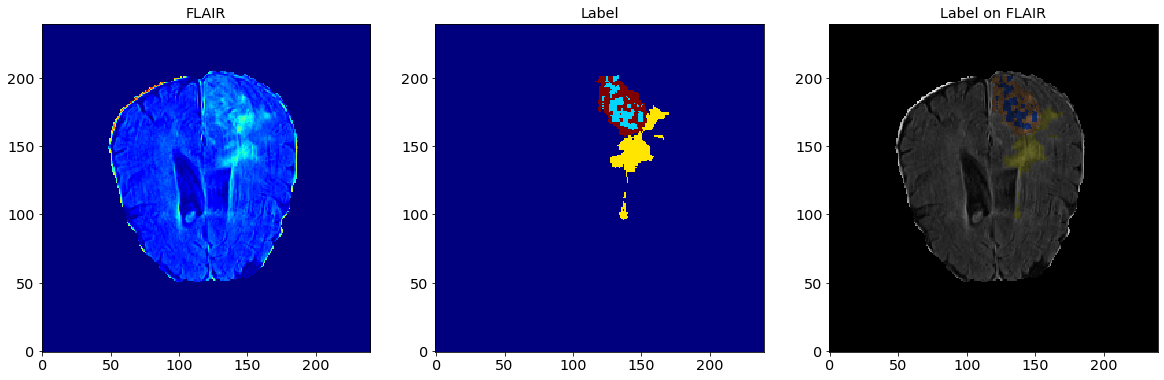

<Figure size 432x360 with 0 Axes>

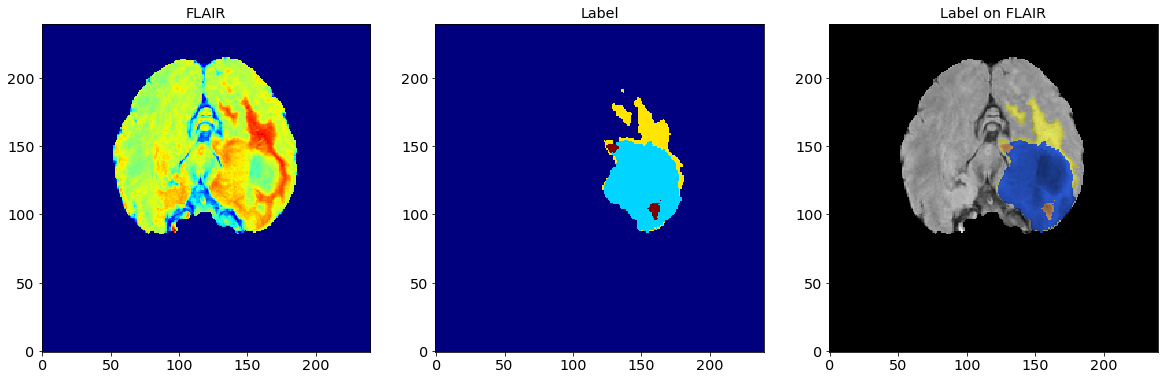

In [37]:
ind=[6,8]
for i in ind:show_img_lable(imtest[i], lbtest[i])

Test the faster generator. Takes:
```
CPU times: user 1.58 s, sys: 6.29 s, total: 7.87 s
Wall time: 12.4 s
```
for 32 batch size

In [38]:
#***
from keras.utils import np_utils
def generate_faste_train_batch(batch_size = 12, df = df_train ,np_dir=NUMPY_DIR):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 4), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
        
        df_batch = df.sample(3)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        batch_images[0:batch_size//2]=b_images[0:batch_size//2]
        batch_label[0:batch_size//2]=b_label[0:batch_size//2]
        
        i=batch_size//2
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i] = np_utils.to_categorical(lbl, 4)
            i+=1
                        
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i] = np_utils.to_categorical(lbl, 4)
            i+=1

        batch_images, batch_label = shuffle(batch_images, batch_label)
            
        yield batch_images, batch_label

In [39]:
%%time
gen_train_fast = generate_faste_train_batch(batch_size=16)
bimg,blbl = next(gen_train_fast)
bimg.shape, blbl.shape

133
74
128
43
97
30
Wall time: 17.4 s


((16, 240, 240, 4), (16, 240, 240, 4))

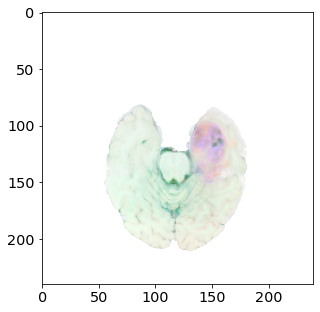

In [40]:
plt.imshow(normalize_2D_image(bimg[8]))

Slower train batch, but more ballanced in labels,

Define train generator and test that it works correctly.
> Takes: 
CPU times: 
user 2.52 s, sys: 12 s, total: 14.5 s
Wall time: 29.2 s
> for batch size 32 

In [41]:
#***

def generate_train_batch(batch_size = 12, df = df_train):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 1), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
         
        i = 0
        
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
            
        
        # lab 2
        nim = batch_size//2
        for j in range(nim):
            im,lbl = get_img_for_label(lab=2, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
            
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1

        # The rest
        nim = batch_size - i
        for j in range(nim):
            im,lbl = get_random_img(axis=random.choice([0,1,2]), df=df)
            batch_images[i] = im/im.max()
            batch_label[i,:,:,0] = lbl
            i+=1
                    
        batch_images, batch_label = shuffle(batch_images, batch_label)
            
        yield batch_images, np_utils.to_categorical(batch_label, 4)

In [42]:
%%time
gen_train = generate_train_batch(batch_size=8)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

Wall time: 11.6 s


((8, 240, 240, 4), (8, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

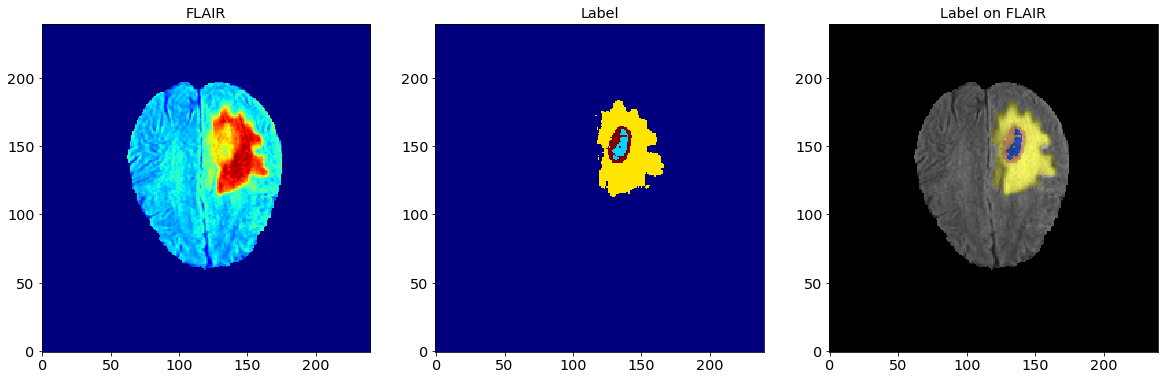

In [43]:
i=7
show_img_lable(bimg[i], blbl[i])

Test the generator
```
CPU times: user 2.53 s, sys: 12.4 s, total: 14.9 s
Wall time: 24.7 s
```

In [44]:
%%time
gen_test = generate_train_batch(36,df_test)
bimg,blbl = next(gen_test)
bimg.shape, blbl.shape

Wall time: 40.1 s


((36, 240, 240, 4), (36, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

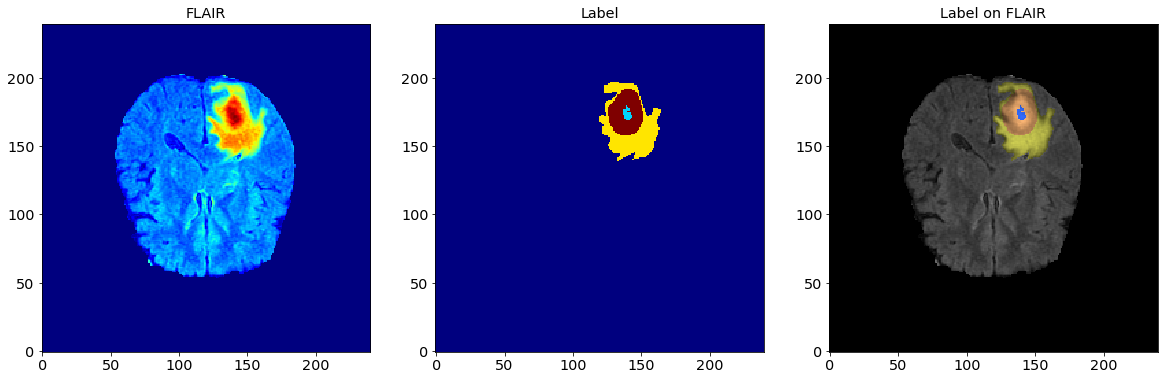

In [45]:
i=6
show_img_lable(bimg[i], blbl[i])

## define Base Unet Model

In [46]:
import tensorflow as tf
from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input, UpSampling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [47]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_CHANNELS = 4

In [48]:
import model_unet
reload(model_unet)

<module 'model_unet' from 'C:\\env\\model_unet.py'>

In [51]:

#model = model_unet.unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
model = model_unet.unet(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [49]:
model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [51]:
%%time
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

Wall time: 0 ns


In [52]:
%%time
history = model.fit_generator(gen_train_fast,
                                        validation_data = gen_test_im, validation_steps=1,
                                              steps_per_epoch=30,
                              epochs=20,
                    callbacks=[earlystopper, checkpointer, reduce_lr])

Epoch 1/20
105
27
95
54
82
35
93
61
122
58
114
39
110
34
131
47
102
40
127
37
100
31
127
52
133
55
131
64
88
29
97
30
129
48
99
35
127
52
100
31
131
81
132
47
136
46
131
64
105
27
110
34
113
29
89
27
127
52
70
19
89
33
83
27
136
71
105
27
126
74
129
48
73
23
91
26
117
55
126
69
113
51
131
47
129
60
131
81
110
33
107
35
122
58
113
29
110
34
117
46
126
74
105
27
98
26
104
48
131
81
122
38
82
35
106
29
129
48
133
67
117
46
129
53
100
28
100
31
112
61
107
35
112
61
131
55
74
30
108
37
126
69
100
42
108
30
107
56
126
66
103
48
109
54
128
57
 1/30 [>.............................] - ETA: 1:26:37 - loss: 1.5205 - accuracy: 0.0124134
67
112
46
68
36
103
28
108
37
70
24
87
48
79
31
125
35
127
67
134
67
128
59
114
59
142
86
133
74
130
102
 2/30 [=>............................] - ETA: 1:11:35 - loss: 1.3538 - accuracy: 0.398381
27
136
62
101
68
 3/30 [==>...........................] - ETA: 1:04:30 - loss: 1.1769 - accuracy: 0.5832101
68
123
68
115
37
 4/30 [===>..........................] - ETA: 1

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


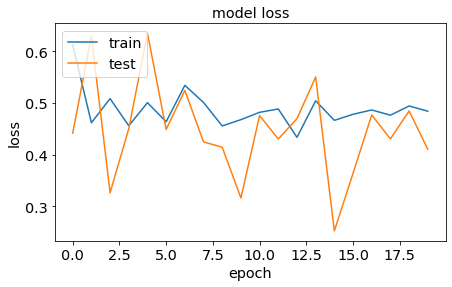

In [53]:
vu.drow_history(history)

In [49]:
model.save_weights('model_unet_ce.hdf5')

NameError: name 'model' is not defined

In [52]:
model.load_weights('model_unet_4ch.hdf5')

## Predict with trained model

Function converts probabilities to labels

In [53]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

In [54]:
def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

In [55]:
def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 240, 240),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch  

In [56]:
def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

In [57]:
def predict_3D_img_prob(np_file):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((155, 240, 240, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img

## Predict on Test images

In [58]:
df_test.head()

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,LGG,BraTS19_TCIA09_255_1,8697118,110787,118819,1276,28,111,64,197,85,180
1,LGG,BraTS19_TCIA13_618_1,8859707,50291,18002,0,26,91,63,128,66,121
2,HGG,BraTS19_TCIA03_498_1,8850722,7328,55793,14157,40,102,82,182,132,182
3,HGG,BraTS19_CBICA_AQU_1,8827121,10976,63649,26254,45,132,108,200,57,110
4,HGG,BraTS19_CBICA_ASK_1,8844582,1588,75783,6047,52,127,147,212,116,167


In [59]:
img_id = 'BraTS19_TCIA03_498_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_TCIA03_498_1')
im.shape,lb.shape

((155, 240, 240, 4), (155, 240, 240))

In [60]:
nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

(155, 240, 240, 4)

In [61]:
pred = prediction_from_probabily_3D(pred_stats)
pred.shape

(155, 240, 240)

In [62]:
np.unique(pred)

array([0])

View predicted probabilities, and the resulted labels

<Figure size 432x360 with 0 Axes>

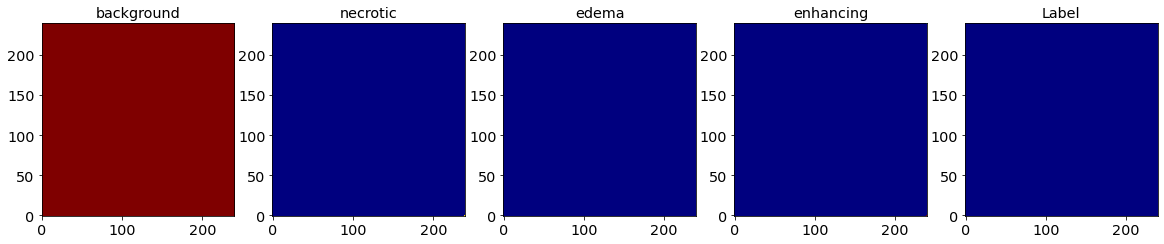

<Figure size 432x360 with 0 Axes>

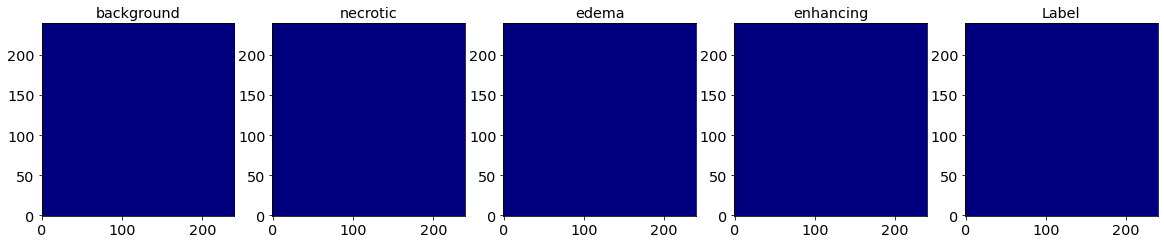

<Figure size 432x360 with 0 Axes>

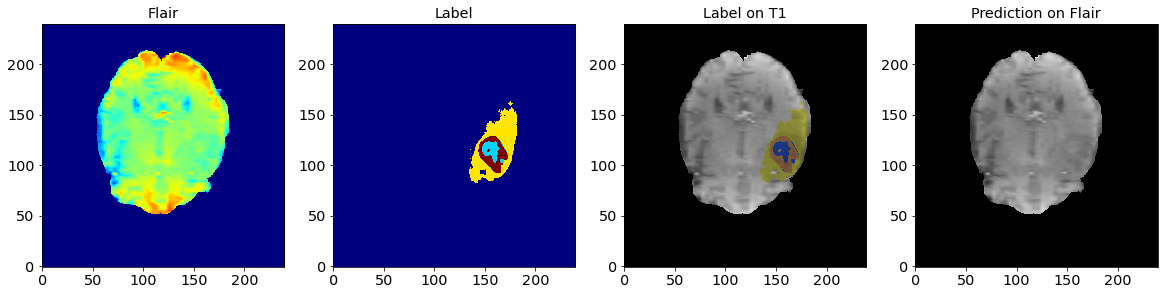

<Figure size 432x360 with 0 Axes>

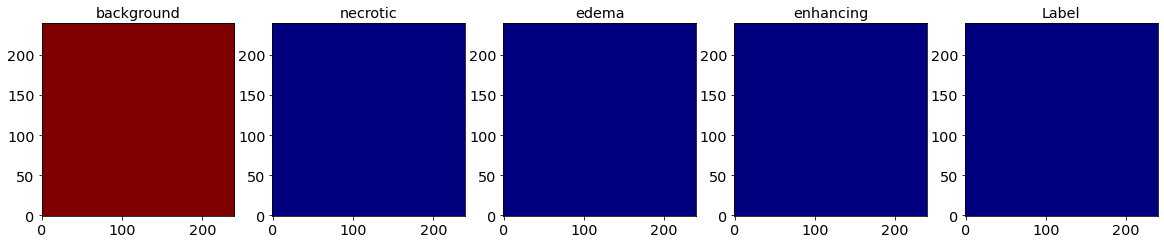

<Figure size 432x360 with 0 Axes>

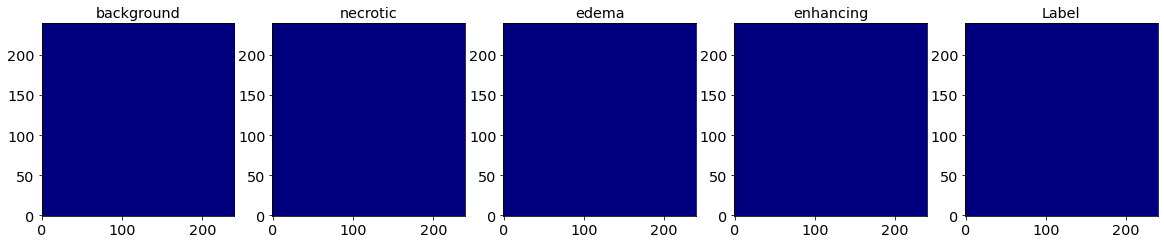

<Figure size 432x360 with 0 Axes>

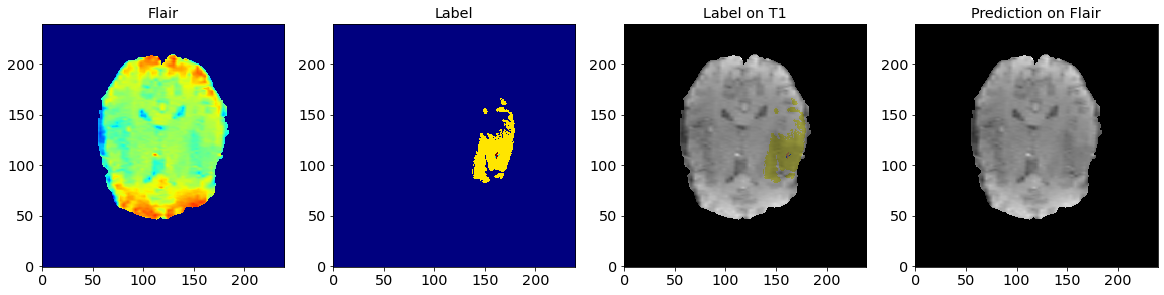

<Figure size 432x360 with 0 Axes>

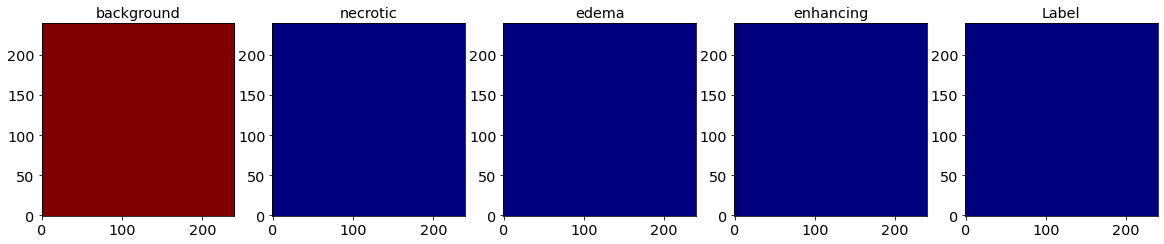

<Figure size 432x360 with 0 Axes>

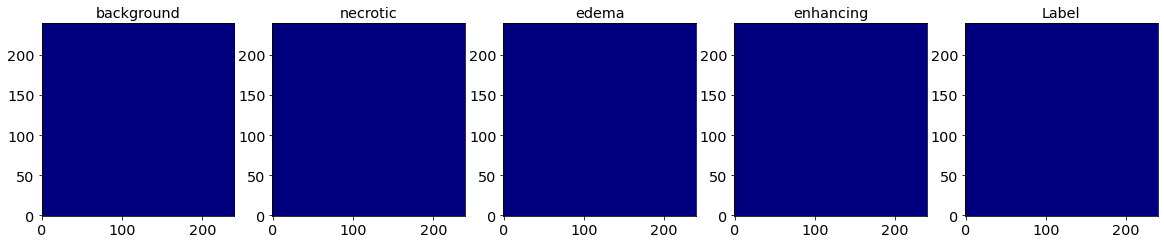

<Figure size 432x360 with 0 Axes>

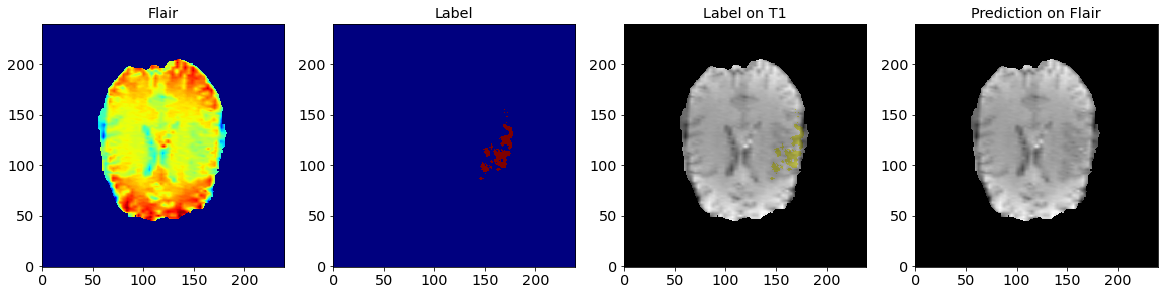

In [79]:
ind=[70,80,90]
for i in ind:
    show_lable(pred_stats[i])
    show_lable(get_pred(pred_stats[i]))
    show_pred_im_lable(im[i], lb[i], pred[i])

## Predict all test images to calculate IOU

In [80]:
TEST_PRED_NUMPY_DIR = 'dicom/predictions/pred1/test/numpy_images/'
VALIDATION_PRED_NUMPY_DIR = 'dicom/predictions/pred1/validation/numpy_images/'
VALIDATION_PRED_NII_DIR = 'dicom/predictions/pred1/validation/nii/'

Check that its all working -:)

In [81]:
img_id = 'BraTS19_2013_17_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_17_1')
im.shape,lb.shape

nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

pred = prediction_from_probabily_3D(pred_stats)
pred.shape

(155, 240, 240)

<Figure size 432x360 with 0 Axes>

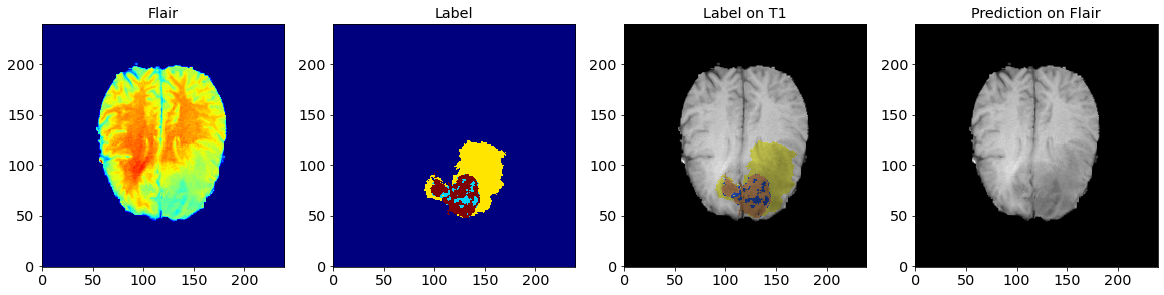

In [82]:
show_pred_im_lable(im[100], lb[100], pred[100])

In [ ]:
for index, row in df_test.iterrows():

    img_id = row['id']
    im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_17_1')

    nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')

    np.save(out_img, pred)

## Predict all validation image

In [63]:
df_val.head()

,id,lab0,lab1,lab2,lab3
0,BraTS19_CBICA_ARZ_1,0,0,0,0
1,BraTS19_TCIA06_409_1,0,0,0,0
2,BraTS19_TCIA10_387_1,0,0,0,0
3,BraTS19_CBICA_AQN_1,0,0,0,0
4,BraTS19_CBICA_AUN_1,0,0,0,0


<Figure size 432x360 with 0 Axes>

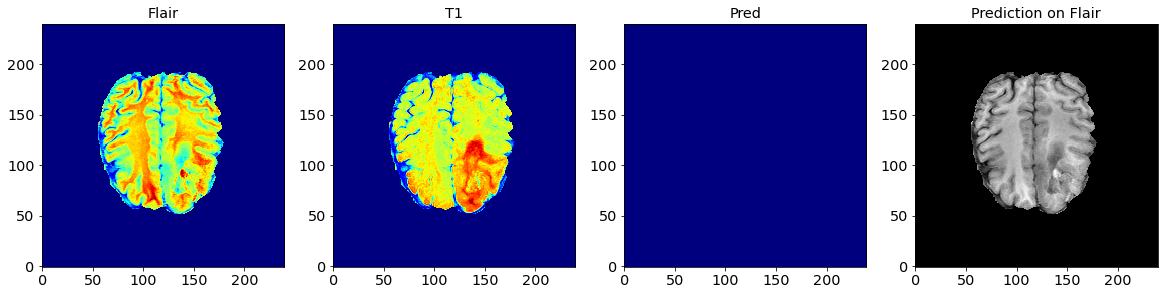

In [65]:
img_id='BraTS19_TCIA10_387_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[100], pred[100])

In [ ]:
for index, row in df_val.iterrows():

    img_id = row['id']

    nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(VALIDATION_PRED_NUMPY_DIR, img_id+'_pred.npy')
    np.save(out_img, pred)
    
    pred = np.where(pred==3,4, pred)
    out_nii = os.path.join(VALIDATION_PRED_NII_DIR, img_id+'.nii.gz')

    sitk_img = sitk.GetImageFromArray(pred)
    sitk.WriteImage(sitk_img , out_nii)